
# Introduction to Social Data Science: Text as Data

#### Required readings

*(PML) Raschka, Sebastian, and Mirjalili, Vahid. Python Machine Learning - Second Edition. Birmingham: Packt Publishing, Limited, 2017. Chapter 8*

- PML: following sections from chapter 8:
¬† - Preparing the IMDb movie review data for text processing
¬† - Introducing the bag-of-words model
¬† - Training a logistic regression model for document classification
¬†
Gentzkow, M., Kelly, B.T. and Taddy, M., 2017. ["Text as data"](http://www.nber.org/papers/w23276.pdf) (No. w23276). *National Bureau of Economic Research*.

Jurafsky, D., & Martin, J. H. (2019). Vector Semantics and Embeddings. Speech and Language Processing, 3rd ed. draft. https://web.stanford.edu/~jurafsky/slp3/6.pdf




#### Inspirational readings

Gorrell, Genevieve et al. ‚ÄúTwits, Twats and Twaddle: Trends in Online Abuse towards UK Politicians.‚Äù ICWSM (2018). https://gate-socmedia.group.shef.ac.uk/wp-content/uploads/2019/07/Gorrell-Greenwood.pdf

Pang, Bo et al. ‚ÄúThumbs up? Sentiment Classification using Machine Learning Techniques.‚Äù EMNLP (2002). https://www.aclweb.org/anthology/W02-1011.pdf 







Course page: https://isdsucph.github.io/isds2021/

**Agenda**
- Preprocessing text
- Feature extraction
- Text classification with ML and using lexicons

## Import packages

In [47]:
# from the textbook, for printing a process bar.
import pyprind

# basic packages
import pandas as pd
import os
import numpy as np
import re # python regular expressions
import string # for efficient operations with strings
import matplotlib.pyplot as plt
%matplotlib inline

# For creating dictionaries that you can fill in a loop
from collections import defaultdict

# NLTK: A basic, popular NLP package. Find many examples of applications at https://www.nltk.org/book/
# Install guide: https://www.nltk.org/install.html
import nltk
nltk.download('punkt') # you will probably need to do this
nltk.download('wordnet') # and this
nltk.download('stopwords') # aand this

# for vectorization 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Vader Lexicon for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# similarity/distance measures
from scipy.spatial import distance
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

# for classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Lexicons for sentiment analysis
from vaderSentiment import vaderSentiment
from afinn import Afinn

# to display images in notebook
from IPython.display import Image

[nltk_data] Downloading package punkt to /Users/terne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/terne/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/terne/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preparing data (following PML chapter 8)

Data source:

Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

Download from http://ai.stanford.edu/~amaas/data/sentiment/




In [3]:
# download the data
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz


--2020-07-23 09:02:47--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu... 171.64.68.10
Connecting to ai.stanford.edu|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: 'aclImdb_v1.tar.gz'

aclImdb_v1.tar.gz   100%[=====================>]  80.23M  4.52MB/s   in 44s    

2020-07-23 09:03:31 (1.81 MB/s) - 'aclImdb_v1.tar.gz' saved [84125825/84125825]



In [4]:
# unpack
import tarfile
with tarfile.open("aclImdb_v1.tar.gz", "r:gz") as tar:
    tar.extractall()

In [5]:
# load data into a pandas DataFrame

basepath = "aclImdb"

labels = {"pos":1, "neg":0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()
for s in ("test", "train"):
    for l in ("pos", "neg"):
        path = os.path.join(basepath,s,l)
        for file in sorted(os.listdir(path)):
            with open(os.path.join(path,file), "r", encoding="utf-8") as infile:
                txt = infile.read()
            # Here I also append s ("train" or "test") to later use the predefined 
            # split of the data. They didn't do this in the textbook.
            df = df.append([[txt, labels[l], s]], ignore_index=True) 
            pbar.update()
df.columns = ["review", "sentiment", "set"]

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:44


In [6]:
df # look at the dataframe

review  sentiment    set
0      I went and saw this movie last night after bei...          1   test
1      Actor turned director Bill Paxton follows up h...          1   test
2      As a recreational golfer with some knowledge o...          1   test
3      I saw this film in a sneak preview, and it is ...          1   test
4      Bill Paxton has taken the true story of the 19...          1   test
5      I saw this film on September 1st, 2005 in Indi...          1   test
6      Maybe I'm reading into this too much, but I wo...          1   test
7      I felt this film did have many good qualities....          1   test
8      This movie is amazing because the fact that th...          1   test
9      "Quitting" may be as much about exiting a pre-...          1   test
10     I loved this movie from beginning to end.I am ...          1   test
11     I was fortunate to attend the London premier o...          1   test
12     I first saw this movie on IFC. Which is a grea...          1   test
13     I must say, every time I see this movie, I am ...          1   test
14     My wife is a mental health therapist and we wa...          1   test
15     I saw this film at the Rotterdam International...          1   test
16     "Night of the Hunted" stars French porn star B...          1   test
17     Even if you're a fan of Jean Rollin's idiosync...          1   test
18     I was surprised how much I enjoyed this. Sure ...          1   test
19     I went into "Night of the Hunted" not knowing ...          1   test
20     I have certainly not seen all of Jean Rollin's...          1   test
21     Since this cartoon was made in the old days, F...          1   test
22     Despite the title and unlike some other storie...          1   test
23     Felix in Hollywood is a great film. The versio...          1   test
24     A gem of a cartoon from the silent era---it wa...          1   test
25     This short is one of the best of all time and ...          1   test
26     Felix is watching an actor rehearse his lines:...          1   test
27     While I can't say whether or not Larry Hama ev...          1   test
28     Errol Flynn's roguish charm really shines thro...          1   test
29     Warner Brothers tampered considerably with Ame...          1   test
...                                                  ...        ...    ...
49970  I remember watching this movie several times a...          0  train
49971  The first scene in 'Problem Child' has a baby ...          0  train
49972  This kid is rather bad, but in no way do they ...          0  train
49973  My girlfriend and I were stunned by how bad th...          0  train
49974  This is one of the worst movies I have ever se...          0  train
49975  Having just recently re-viewed "Lipstick" for ...          0  train
49976  Don't waste 90 minutes of your time on "Fast F...          0  train
49977  This movie was billed as a comedy and a myster...          0  train
49978  Story starts slow and nothing funny happens fo...          0  train
49979  This film is a massive Yawn proving that Ameri...          0  train
49980  It was a Sunday night and I was waiting for th...          0  train
49981  Have I ever seen a film more shockingly inept?...          0  train
49982  The next time you are at a party and someone a...          0  train
49983  Turgid dialogue, feeble characterization - Har...          0  train
49984  Cameron Diaz is a woman who is married to a ju...          0  train
49985  I had the misfortune to watch this rubbish on ...          0  train
49986  It's pretty bad when the generic movie synopsi...          0  train
49987  Having watched this movie on the SciFi channel...          0  train
49988  First off, I'm not here to dog this movie. I f...          0  train
49989  Ah yez, the Sci Fi Channel produces Yeti anoth...          0  train
49990  Yeti: Curse of the Snow Demon starts aboard a ...          0  train
49991  Hmmm, a sports team is in a plane crash, gets ...          0  train


In [7]:
# dividing into train and test set again.
df_train = df[df.set=="train"]
df_test = df[df.set=="test"]

# Permute data such that pos and neg samples are mixed

np.random.seed(0)
df_train = df.reindex(np.random.permutation(df_train.index))
df_test = df.reindex(np.random.permutation(df_test.index))

# save dataframes:
df_train.to_csv("train.csv", index=False)
df_test.to_csv("test.csv", index=False)

In [2]:
# load saved dataframes:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train.head()

review  sentiment    set
0  Forbidden Siren is based upon the Siren 2 Play...          0  train
1  You better see this episode from the beginning...          1  train
2  This is one of those movies that's trying to b...          0  train
3  I have seen this film numerous times and for t...          1  train
4  Let's face it: the final season (#8) was one o...          1  train

# Preprocessing
 We preprocess text data to standardize the format and to define what a unique "feature" is.
 
 
 *What is a feature?* 
 Features are the independent variables. A flower may have features such as color and leaf length, and you can use such features to classify flowers into species. 
 With text data, a feature is commonly a word (or a character in some special cases). If we have a small collection of texts where 2500 *unique* words are used, we commonly say that the *vocabulary* is of size 2500 and the number of features is equal to the size of the vocabulary.
 
 For most types of analysis, we have to represent each feature with some numerical values. But, this is where the importance of preprocessing comes in: Should the words "try" and "trying" have different values or do they convey the same basic information? What about "USA" and "usa"? And are punctuations important? 

 
When working with text as data, the number of features is much larger than when working with most other types as data. Preproccessing is therefore both about standardizing the data and about trying to reduce the number of features to relieve the computation cost.

The most standard preprocessing steps are:

- Segmentation (dividing a string into reasonable sentences and words)
- Lowercasing (standardizing)
- Stemming or lemmatizing (standardizing)
- Removing so-called stopwords and punctuation and other potentially disrupting text patterns (reducing "noise" and feature dimensionality)


What features are important, and hence which preprocessing steps should be included/excluded, depends on the task / research question.
 

## Tokenization (segmentation)

In [4]:
sentence = df_train.review.values[0]
print(sentence)
 
# word tokenization (segmentation)
# by blank space (crude)
sent = sentence.split(" ")
print(sent)
# by using a package such as NLTK.
sent = nltk.tokenize.word_tokenize(sentence)
print(sent)
# nltk.tokenize.TweetTokenizer() is another option, and good for social media text.

# Sentence segmentation (sentence splitting)
sents = nltk.tokenize.sent_tokenize(sentence)
print(sents)

# There are many other more complex versions used for specific cases/tasks/models and sometime you may want to costumize the segmentation.
# Learn more: https://web.stanford.edu/~jurafsky/slp3/2.pdf

Forbidden Siren is based upon the Siren 2 Playstation 2 (so many 2s) game. Like most video game turned movies, I would say the majority don't translate into a different medium really well. And that goes for this one too, painfully.<br /><br />There's a pretty long prologue which explains and sets the premise for the story, and the mysterious island on which a writer (Leo Morimoto) and his children, daughter Yuki (Yui Ichikawa) and son Hideo (Jun Nishiyama) come to move into. The villagers don't look all too friendly, and soon enough, sound advice is given about the siren on the island, to stay indoors once the siren starts wailing.<br /><br />Naturally and slowly, things start to go bump, and our siblings go on a mission beating around the bush to discover exactly what is happening on this unfriendly island with its strange inhabitants. But in truth, you will not bother with what's going on, as folklore and fairy tales get thrown in to convolute the plot even more. What was really push

## Stemming or lemmatising

**Stemming**: Stripping the word down to it's central meaning (it's stem) by removing affixes. Stemming usually only removes suffixes (i.e. affixes at the end of the words).

E.g.: 

sings --> sing

laughing --> laugh

wonderful --> wonder


**Lemmatizing**: "the task of determining that two words have the same root, despite their surface differences. For example, the words sang, sung, and sings are forms of the verb sing. The word sing is the common lemma of these words, and a lemmatizer maps from all of these to sing." (Jurafsky, D., & Martin, J. H., 2019. Chap. 2, p. 2)


In [4]:
def stem(word):
    # find suffixes and return stems
    # (.*?) matches any character in front of a word (non greedy version)
    regexp = r'^(.*?)(ing|ly|ed|ious|ies|ive|es|s|ment)?$'
    stem, suffix = re.findall(regexp, word)[0]
    return stem

# Tokenize the text first
tokens = nltk.word_tokenize(sentence)
#print(tokens)

print([stem(t) for t in tokens]) # hmm not so good

['Forbidden', 'Siren', 'i', 'bas', 'upon', 'the', 'Siren', '2', 'Playstation', '2', '(', 'so', 'many', '2', ')', 'game', '.', 'Like', 'most', 'video', 'game', 'turn', 'mov', ',', 'I', 'would', 'say', 'the', 'majority', 'do', "n't", 'translate', 'into', 'a', 'different', 'medium', 'real', 'well', '.', 'And', 'that', 'go', 'for', 'thi', 'one', 'too', ',', 'painfully.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'There', "'", 'a', 'pretty', 'long', 'prologue', 'which', 'explain', 'and', 'set', 'the', 'premise', 'for', 'the', 'story', ',', 'and', 'the', 'myster', 'island', 'on', 'which', 'a', 'writer', '(', 'Leo', 'Morimoto', ')', 'and', 'hi', 'children', ',', 'daughter', 'Yuki', '(', 'Yui', 'Ichikawa', ')', 'and', 'son', 'Hideo', '(', 'Jun', 'Nishiyama', ')', 'come', 'to', 'move', 'into', '.', 'The', 'villager', 'do', "n't", 'look', 'all', 'too', 'friend', ',', 'and', 'soon', 'enough', ',', 'sound', 'advice', 'i', 'given', 'about', 'the', 'siren', 'on', 'the', 'island', ',', 'to', 'stay', 

In [5]:
# using NLTK's Porter stemmer
porter = nltk.PorterStemmer()
#print(sentence)
print([porter.stem(t) for t in tokens])

['forbidden', 'siren', 'is', 'base', 'upon', 'the', 'siren', '2', 'playstat', '2', '(', 'so', 'mani', '2s', ')', 'game', '.', 'like', 'most', 'video', 'game', 'turn', 'movi', ',', 'i', 'would', 'say', 'the', 'major', 'do', "n't", 'translat', 'into', 'a', 'differ', 'medium', 'realli', 'well', '.', 'and', 'that', 'goe', 'for', 'thi', 'one', 'too', ',', 'painfully.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'there', "'s", 'a', 'pretti', 'long', 'prologu', 'which', 'explain', 'and', 'set', 'the', 'premis', 'for', 'the', 'stori', ',', 'and', 'the', 'mysteri', 'island', 'on', 'which', 'a', 'writer', '(', 'leo', 'morimoto', ')', 'and', 'hi', 'children', ',', 'daughter', 'yuki', '(', 'yui', 'ichikawa', ')', 'and', 'son', 'hideo', '(', 'jun', 'nishiyama', ')', 'come', 'to', 'move', 'into', '.', 'the', 'villag', 'do', "n't", 'look', 'all', 'too', 'friendli', ',', 'and', 'soon', 'enough', ',', 'sound', 'advic', 'is', 'given', 'about', 'the', 'siren', 'on', 'the', 'island', ',', 'to', 'stay', 'in

In [6]:
# using the WordNet lemmatizer through NLTK
# WordNet is a large lexical database of English (think "lexicon")
wnl = nltk.WordNetLemmatizer()
print(sentence)
print([wnl.lemmatize(t) for t in tokens])
# note the differences.. this lemmatizer knows that the word "based" does not have the same meaning as "base" here. 
# Seems more comprehensible. Or lot less has actually changed. (examples: "goes" became "go" and "villagers" became "villager")

Forbidden Siren is based upon the Siren 2 Playstation 2 (so many 2s) game. Like most video game turned movies, I would say the majority don't translate into a different medium really well. And that goes for this one too, painfully.<br /><br />There's a pretty long prologue which explains and sets the premise for the story, and the mysterious island on which a writer (Leo Morimoto) and his children, daughter Yuki (Yui Ichikawa) and son Hideo (Jun Nishiyama) come to move into. The villagers don't look all too friendly, and soon enough, sound advice is given about the siren on the island, to stay indoors once the siren starts wailing.<br /><br />Naturally and slowly, things start to go bump, and our siblings go on a mission beating around the bush to discover exactly what is happening on this unfriendly island with its strange inhabitants. But in truth, you will not bother with what's going on, as folklore and fairy tales get thrown in to convolute the plot even more. What was really push

## Casing, stopwords, punctuation etc.

In [5]:
# Casing (lower casing is normal procedure such that the word "That", after a punctuation, and "that" are not treated as two seperate features.
sent = sentence.lower()
print(sent)
# Note: you may want some exceptions, e.g. distinction between US and us can be important for some tasks.


# lowercase and then tokenize all texts in the training set ‚Äì in one list comprehension:
train_sents = [nltk.word_tokenize(i.lower()) for i in df_train.review.values]
print(train_sents[0])
# And do the same with the test set
test_sents = [nltk.word_tokenize(i.lower()) for i in df_test.review.values]


forbidden siren is based upon the siren 2 playstation 2 (so many 2s) game. like most video game turned movies, i would say the majority don't translate into a different medium really well. and that goes for this one too, painfully.<br /><br />there's a pretty long prologue which explains and sets the premise for the story, and the mysterious island on which a writer (leo morimoto) and his children, daughter yuki (yui ichikawa) and son hideo (jun nishiyama) come to move into. the villagers don't look all too friendly, and soon enough, sound advice is given about the siren on the island, to stay indoors once the siren starts wailing.<br /><br />naturally and slowly, things start to go bump, and our siblings go on a mission beating around the bush to discover exactly what is happening on this unfriendly island with its strange inhabitants. but in truth, you will not bother with what's going on, as folklore and fairy tales get thrown in to convolute the plot even more. what was really push

In [8]:
# Removing certain words (stopwords)
stop_words_list = nltk.corpus.stopwords.words("english")
print(stop_words_list)
print()
sent_sw_removed = [i for i in nltk.word_tokenize(sentence.lower()) if i not in stop_words_list]
print(sent_sw_removed)
#train_sents_sw_removed = [[i for i in sent if i not in stop_words_list] for sent in train_sents] # nested list comprehension; lists in list.
#test_sents_sw_removed = [[i for i in sent if i not in stop_words_list] for sent in test_sents]
#print(train_sents_sw_removed[0])

# unfortunately the tokenization does not totally align with the stopwords ‚Äì the simple split at whitespace may be more appropiate before stopword removal.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
# Removing punctuation, two ways:

punct_removed_1 = sentence.translate(str.maketrans('', '', string.punctuation))
print(punct_removed_1)

#def removePunctuation (word):
#    return re.sub("[^\w\s\-\']", "", word)

punct_removed_2 = re.sub(r'[^\w\s]','',sentence) # learn more about regex at https://www.datacamp.com/community/tutorials/python-regular-expression-tutorial or find a cheat sheet.
print(punct_removed_2)

Forbidden Siren is based upon the Siren 2 Playstation 2 so many 2s game Like most video game turned movies I would say the majority dont translate into a different medium really well And that goes for this one too painfullybr br Theres a pretty long prologue which explains and sets the premise for the story and the mysterious island on which a writer Leo Morimoto and his children daughter Yuki Yui Ichikawa and son Hideo Jun Nishiyama come to move into The villagers dont look all too friendly and soon enough sound advice is given about the siren on the island to stay indoors once the siren starts wailingbr br Naturally and slowly things start to go bump and our siblings go on a mission beating around the bush to discover exactly what is happening on this unfriendly island with its strange inhabitants But in truth you will not bother with whats going on as folklore and fairy tales get thrown in to convolute the plot even more What was really pushing it into the realm of bad comedy are it

## Exercise 1: preprocessing
Make a preprocessing function that takes a single string and 
 1) Lowercase the words,
 2) split the text into words (tokenize), 
 3) either stem or lemmatize words.
Feel free to add more steps of preprocessing. For example stopword removal or removal of what seems to be HTML elements (such as "< br/>") in the text, and removal of punctuation, and handling of emoticons as in the textbook.

In [7]:
def preprocess(text):
    # YOUR CODE HERE
    
    # solution included in assignment 2
    
    return lemmas # return a list of stems/lemmas

sentence = df_train.review.values[0]
print(preprocess(sentence))


['forbidden', 'siren', 'is', 'based', 'upon', 'the', 'siren', '2', 'playstation', '2', 'so', 'many', '2', 'game', 'like', 'most', 'video', 'game', 'turned', 'movie', 'i', 'would', 'say', 'the', 'majority', 'dont', 'translate', 'into', 'a', 'different', 'medium', 'really', 'well', 'and', 'that', 'go', 'for', 'this', 'one', 'too', 'painfullybr', 'br', 'there', 'a', 'pretty', 'long', 'prologue', 'which', 'explains', 'and', 'set', 'the', 'premise', 'for', 'the', 'story', 'and', 'the', 'mysterious', 'island', 'on', 'which', 'a', 'writer', 'leo', 'morimoto', 'and', 'his', 'child', 'daughter', 'yuki', 'yui', 'ichikawa', 'and', 'son', 'hideo', 'jun', 'nishiyama', 'come', 'to', 'move', 'into', 'the', 'villager', 'dont', 'look', 'all', 'too', 'friendly', 'and', 'soon', 'enough', 'sound', 'advice', 'is', 'given', 'about', 'the', 'siren', 'on', 'the', 'island', 'to', 'stay', 'indoors', 'once', 'the', 'siren', 'start', 'wailingbr', 'br', 'naturally', 'and', 'slowly', 'thing', 'start', 'to', 'go', '

In [17]:
# Have a look at the size of the vocabulary of the train data that 
# has only been lower-cased and tokenized (a few cells above).

d = defaultdict(int)
for i in train_sents:
    for w in i:
        d[w]+=1
V = d.keys()
print("Vocabulary size:",len(V))

# inspect the 10 most frequent tokens:
{k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)[:10]}


Vocabulary size: 113962


{'the': 334753,
 ',': 275888,
 '.': 235397,
 'and': 163334,
 'a': 162222,
 'of': 145399,
 'to': 135146,
 'is': 110249,
 '/': 102097,
 '>': 102036}

In [18]:
# Now do it yourself with your train data after preprocessing:

# YOUR CODE HERE

# Solution
text_processed = [preprocess(sent) for sent in df_train.review.values]
d = defaultdict(int)
for i in text_processed:
    for w in i:
        d[w]+=1
V = d.keys()
print("Vocabulary size:",len(V))

# inspect the N most frequent tokens (you decide which N to use):
N = 10
{k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)[:N]}

Vocabulary size: 112379


{'the': 334696,
 'a': 208603,
 'and': 162228,
 'of': 145326,
 'to': 135042,
 'is': 106855,
 'it': 102164,
 'in': 93049,
 'i': 75732,
 'this': 75190}

Without preprocessing we see "words" in the vocabulary that are not words. This is a lesson in the importantance of looking at your (training!) data.
Even with preprocessing, mistakes and nonsense will occur in the data. You can consider altering your preprocessing if you notice many mistakes in the vocabulary.

In [23]:
# Optional: Look at the content of V in some way, and comment on what you could do to improve your preproccessing.
sorted(V)

['\x08\x08\x08\x08a',
 '\x10own',
 '0',
 '00',
 '000',
 '0000000000001',
 '000001',
 '00000110',
 '0001',
 '00015',
 '001',
 '0010',
 '002',
 '00383042',
 '006',
 '007',
 '0079',
 '0080',
 '0083',
 '00s',
 '01',
 '010',
 '01000',
 '010br',
 '010makes',
 '0110',
 '012310',
 '0130',
 '013007',
 '02',
 '029',
 '02br',
 '03',
 '0310',
 '03oct2009',
 '04',
 '041',
 '048',
 '05',
 '050',
 '0510',
 '053105',
 '06',
 '06th',
 '07',
 '07kiloton',
 '08',
 '081006',
 '087',
 '089',
 '08th',
 '09',
 '09082009',
 '091505',
 '09br',
 '0br',
 '0f',
 '0ne',
 '0r',
 '0stars',
 '0when',
 '1',
 '10',
 '100',
 '1000',
 '10000',
 '100000',
 '1000000',
 '10000000',
 '1000000000000',
 '1000000000000010000000000000',
 '10002000',
 '1000lb',
 '1001',
 '100200',
 '100am',
 '100b',
 '100br',
 '100hell',
 '100kin',
 '100m',
 '100min',
 '100minute',
 '100mph',
 '100percent',
 '100plus',
 '100square',
 '100th',
 '100thgrade',
 '100x',
 '100yards',
 '100year',
 '100yearold',
 '100years',
 '101',
 '1010',
 '1010br',


# Feature representation/extraction

In this notebook, the goal is to make a sentiment classification model trained on the movie review data. 

No matter whether we want to make a (supervised) classification model or (unsupervised) clustering of texts and other analyses of text similarities, we will have to transform our features, that are currently strings, into a numerical representation, that will convey the content of a sentence or document in some way. There are many approaches one can take, ranging from very simple representations (such as vectors with binary values for each feature, stating wether the feature/word appears in the given document or not) to very complex representations learned from a seperate prediction model.

One standard, simple approach is called Bag of Words:

## BoW (Bag of Words)

- Represent the texts with a **Term-Document frequency matrix** where each text is represented by a vector of word counts. 
- The creats a matrix with size n_samples x n_features. (n_features = size of vocabulary)

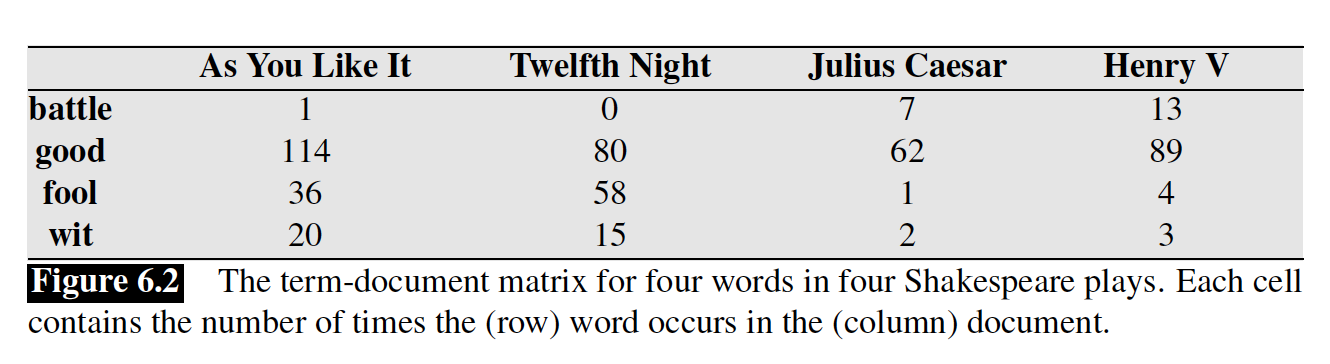

In [3]:
Image("term_document.png") # (Jurafsky, D., & Martin, J. H., 2019. Chap. 6, p. 7)

In [14]:
# CountVectorizer (from sklearn.feature_extraction.text) has a build-in tokenizer and lowercases by default. It also has an option to remove stopwords (look at the documentation).
vectorizer = CountVectorizer()

# You can override the default tokenization with your own defined function, like so:
#vectorizer = CountVectorizer(tokenizer=preprocess)

# you can also restrict the number of features to the top N most frequent features:
#vectorizer = CountVectorizer(max_features=N)

# fit and transform train set
X_train_bow = vectorizer.fit_transform(df_train.review.values)

# Only tranform test set: never fit your vectorizer on the test set (it is cheating). Out-of-Vocabulary words are handled automatically be sklearn's vectorizer.
X_test_bow = vectorizer.transform(df_test.review.values)

In [15]:
print(X_train_bow.shape)
print(len(vectorizer.vocabulary_))
X_train_bow[0]

(25000, 74849)
74849


<1x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 238 stored elements in Compressed Sparse Row format>

Only 238 nonzero elements in the vector of the first text, i.e. 238 unique features/words out of 74,849.

In [26]:
X_train_bow[0].toarray() # the vector is very sparse..

array([[0, 0, 0, ..., 0, 0, 0]])

In [21]:
print(X_train_bow[0]) # here we take a look at the non-zero elements. 
#The first element is the word with ID 25459, which appears two times in the text.

  (0, 25459)	2
  (0, 60440)	5
  (0, 34585)	5
  (0, 6117)	1
  (0, 70377)	1
  (0, 66339)	21
  (0, 50339)	1
  (0, 61380)	2
  (0, 40829)	1
  (0, 605)	1
  (0, 26692)	2
  (0, 38755)	1
  (0, 43995)	1
  (0, 71281)	1
  (0, 68619)	2
  (0, 44164)	1
  (0, 73714)	1
  (0, 57715)	1
  (0, 40413)	1
  (0, 19563)	2
  (0, 67832)	1
  (0, 34255)	4
  (0, 18336)	1
  (0, 41950)	1
  (0, 53839)	2
  :	:
  (0, 21162)	1
  (0, 21289)	1
  (0, 42134)	1
  (0, 38507)	1
  (0, 47142)	1
  (0, 52227)	1
  (0, 31289)	1
  (0, 24125)	1
  (0, 69622)	1
  (0, 6771)	1
  (0, 37895)	1
  (0, 57675)	1
  (0, 28314)	1
  (0, 6334)	2
  (0, 12480)	1
  (0, 70505)	1
  (0, 38720)	1
  (0, 59184)	1
  (0, 43010)	1
  (0, 23199)	1
  (0, 63226)	1
  (0, 73702)	1
  (0, 66925)	1
  (0, 7095)	1
  (0, 5208)	1


In [22]:
print(vectorizer.get_feature_names()[25459]) # this is one way to get the word with the ID 25459

forbidden


In [24]:
#df_train.review.values[0] # you can check that the word "forbidden" appears two times in the first text

### N-grams 

- Collection of 1 or more tokens.

- Bag of words lacks word order and context (semantics). n-grams to the rescue!

In [4]:
example = "The cat in the hat"

In [5]:
def make_ngrams(sentence,n):
    tokens = sentence.split(" ")
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

print("Unigrams:",make_ngrams(example,1))
print("Bigrams:",make_ngrams(example,2))
print("Trigrams:",make_ngrams(example,3))
print("4-grams:",make_ngrams(example,4))
print("5-grams:",make_ngrams(example,5))

Unigrams: ['The', 'cat', 'in', 'the', 'hat']
Bigrams: ['The cat', 'cat in', 'in the', 'the hat']
Trigrams: ['The cat in', 'cat in the', 'in the hat']
4-grams: ['The cat in the', 'cat in the hat']
5-grams: ['The cat in the hat']


### BoW with ngrams using CountVectorizer

In [9]:
# this block can take a few minutes to run

# n=1-5
vectorizer = CountVectorizer(ngram_range=(1,5))

X_train_5gram = vectorizer.fit_transform(df_train.review.values)

In [10]:
print(X_train_5gram.shape)
X_train_5gram[0]

(25000, 15490990)


<1x15490990 sparse matrix of type '<class 'numpy.int64'>'
	with 1811 stored elements in Compressed Sparse Row format>

- But now we have problems with high dimensionalty and uniqeness of features!

- N-grams are used for many applications but are especially known from **Language Models**: In short, probalistic models that learn to predict the next word in a sequence of words, given the "history" (the previous words), simply by storing the probability of this event occuring in the given text, e.g. P(hat|The cat in the). But instead of using ALL previous word (which would be a combination of words unique to the given text), the history is approximated by a few previous words (n-grams), e.g. P(hat|the). This is the n-gram language model.



## Exercise 2: Inspect most frequent bigrams

Inspection of word collocations (bigrams, trigrams etc.) can be a good first step in exploring a new text dataset, or a single document for that matter. Such collocations will be very indicative of what the texts are about.

Make a new CountVectorizer that only includes bigrams and with max_features=1000. Fit it on the train set.

Then, practise you Googling and find a way to print the most frequent bigrams in the train set. Print the bigrams along with their frequencies in a descending order. What do you see?

In [25]:
# YOUR CODE HERE

#SOLUTION 
# With inspiration from https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d

vectorizer = CountVectorizer(ngram_range=(2,2),max_features=1000)

X_train_2gram = vectorizer.fit_transform(df_train.review.values)

sum_words = X_train_2gram.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq

[('br br', 50973),
 ('of the', 39166),
 ('in the', 25224),
 ('this movie', 15746),
 ('the film', 13543),
 ('and the', 13353),
 ('to the', 12000),
 ('to be', 11883),
 ('the movie', 11877),
 ('this film', 10925),
 ('it is', 10145),
 ('this is', 9480),
 ('on the', 8988),
 ('it was', 8637),
 ('one of', 8094),
 ('for the', 8005),
 ('with the', 7891),
 ('br the', 7814),
 ('is the', 6980),
 ('if you', 6907),
 ('at the', 6827),
 ('from the', 6164),
 ('in this', 6156),
 ('as the', 5932),
 ('that the', 5524),
 ('the story', 5365),
 ('to see', 5167),
 ('out of', 5144),
 ('by the', 4872),
 ('movie is', 4658),
 ('the first', 4629),
 ('all the', 4448),
 ('there is', 4425),
 ('have been', 4317),
 ('of this', 4249),
 ('film is', 4128),
 ('is not', 4080),
 ('but it', 4017),
 ('the end', 3806),
 ('that it', 3735),
 ('there are', 3724),
 ('and it', 3686),
 ('the same', 3682),
 ('the most', 3537),
 ('but the', 3478),
 ('the best', 3468),
 ('about the', 3286),
 ('to make', 3284),
 ('the only', 3265),
 ('of

## Term Frequency‚ÄìInverse Document Frequency (TF-IDF)

The tf-idf value of term t in document d is:

TF-IDF(t,d) = tf(t,d) x idf(t)

where,

tf(t,d) = count of term t in document d

N = total number of documents

df(t) = number of documents that term t occurs in

idf(t) = N/df(t)

A "term" is a token in our case.

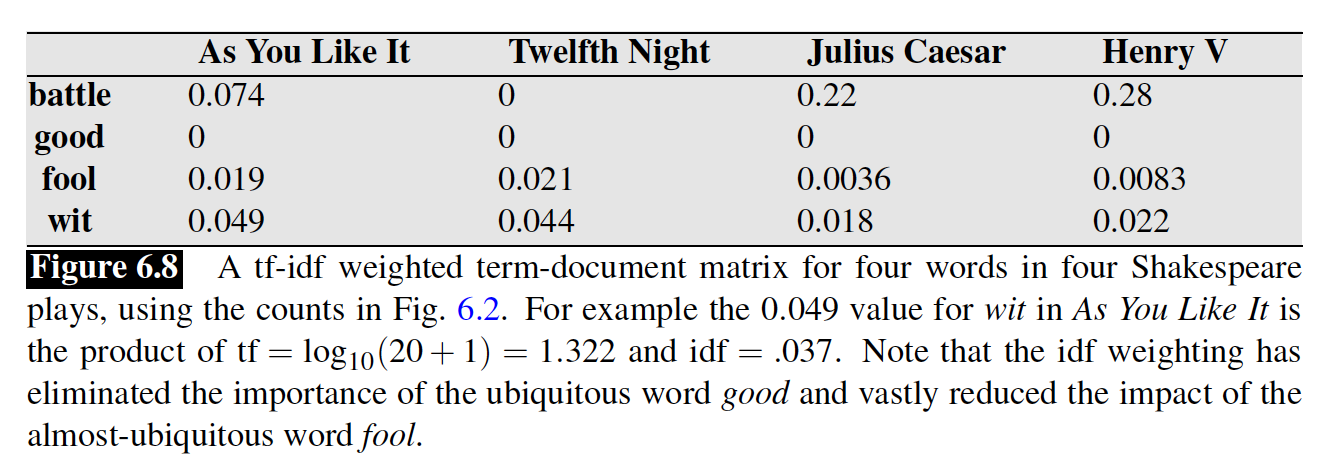

In [4]:
Image("tf_idf.png") # (Jurafsky, D., & Martin, J. H., 2019. Chap. 6, p. 14)

In [18]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(df_train.review.values)

### Document similarity with tf-idf vectors

In [21]:
X_train_tfidf[0].shape

(1, 74849)

In [49]:
# https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
cosine_similarities = cosine_similarity(X_train_tfidf[0], X_train_tfidf).flatten()

indices = cosine_similarities.argsort()[::-1] # in descending order 
print("most similar:",indices[:10])
print("least similar", indices[-9:])

most similar: [    0 23558 23470 17790  4719 24385 20550  6001  6096 20886]
least similar [14867 11975 17497  5623  9340 14494 18802 16480 23603]


In [50]:
print(df_train.review.values[0])
print()
print("most similar: ", df_train.review.values[23558])
print()
print("least similar: ", df_train.review.values[23603])

Forbidden Siren is based upon the Siren 2 Playstation 2 (so many 2s) game. Like most video game turned movies, I would say the majority don't translate into a different medium really well. And that goes for this one too, painfully.<br /><br />There's a pretty long prologue which explains and sets the premise for the story, and the mysterious island on which a writer (Leo Morimoto) and his children, daughter Yuki (Yui Ichikawa) and son Hideo (Jun Nishiyama) come to move into. The villagers don't look all too friendly, and soon enough, sound advice is given about the siren on the island, to stay indoors once the siren starts wailing.<br /><br />Naturally and slowly, things start to go bump, and our siblings go on a mission beating around the bush to discover exactly what is happening on this unfriendly island with its strange inhabitants. But in truth, you will not bother with what's going on, as folklore and fairy tales get thrown in to convolute the plot even more. What was really push

The similar text is also about a movie based on a video games! Also notice the similarity of lengths and that the least similar review is very short.

## Vector semantics / Vector Space Models / (word) embeddings


Semantics: The *meaning* or catagory of a word.

Context is important to understand a word and give it a descriptive representation (encoding it's meaning). 

Assumption/intution: Two words are similar if they appear in similar contexts.

Now, instead just counting the words, we use a seperate model that should learn good feature vectors based on the above assumption. A popular model is called Word2Vec, which can learn feature vectors (i.e. word embeddings) in two different ways:


Word2Vec architectures:

- CBOW: Learn word embeddings by predicting a focus word given a context

- Skip-gram: Learn word embeddings by predicting context words given focus word

(https://arxiv.org/pdf/1301.3781.pdf ,
https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf, https://radimrehurek.com/gensim/models/word2vec.html)

In [8]:
from gensim.models import Word2Vec

# using the train_sents from earlier (the lowercased and tokenized sentences)
model = Word2Vec(train_sents, vector_size=50)#the default learning algorithm is CBOW. To use skip-gram use the paramter sg=1.

# You can load pretrained embeddings downloaded from: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing 
# BUT this takes up a lot of space (the file is over 1 GB) and a lot of RAM when you try to use it.
# If you want to try it, write this:
#model = gensim.models.KeyedVectors.load_word2vec_format(directory_path+'GoogleNews-vectors-negative300.bin', binary=True)


In [9]:
print(model.wv['good'])

[-2.0386133   0.9827179   0.07654309  1.1927067  -0.6066425   2.7542849
 -0.90575844 -3.7955647  -1.7069027  -0.09006034  4.990313    2.794946
 -1.0693339  -3.8994453   0.01020864 -1.0993075   1.1833851   1.3831254
  1.9225681   2.438319   -4.159911   -0.48864052  1.3984704   1.3551116
 -2.0760603  -2.7664306   0.07673543 -1.6644888  -0.5532943  -2.6277432
 -0.33512208 -2.5943608   0.3858204  -0.37323332 -0.3902523  -2.7488396
  0.74834186 -1.0087521  -1.5538292  -3.375781    3.145487   -0.33825037
  0.06971256  1.0857369   2.3755498  -4.081329   -2.6043963   0.6958837
 -2.920059   -1.8793732 ]


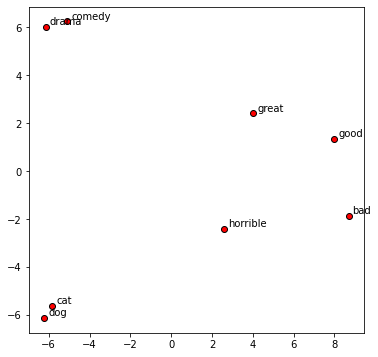

In [10]:
# Reducing the 50-dimensional vectors to 2 dimensions in order to visualise selected words.
from sklearn.decomposition import PCA

words = ["drama","comedy", "good", "great", "bad", "horrible", "cat", "dog"]

X = [model.wv['drama'], model.wv['comedy'], 
     model.wv['good'], model.wv['great'], 
     model.wv['bad'], model.wv['horrible'], 
     model.wv['cat'], model.wv['dog']]

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

plt.figure(figsize=(6,6))
plt.scatter(X_r[:,0], X_r[:,1], edgecolors='k', c='r')
for word, (x,y) in zip(words, X_r):
    plt.text(x+0.2, y+0.1, word)

We now have a unique embedding vector mapped to each word. But what if we want to work with sentences/documents that contain many words and with a variying number of words in them? If you are doing machine learning (and are not using some fancy model that can handle varying lengts), the input vectors for your model have to be of same length. And the input of one element (for example one document), should preferably be a vector rather than a matrix (i.e. having an array with arrays of word embeddings as input will not work in most cases). So you need to make a decision of how to to use word embeddings for such cases. 

You could, for example, concatenate the vectors and choose a cut-off point for a given maximum number of words, where every sentence longer than that will be cut short, and every sentence shorter will be appended vectors containing zeroes. Or you can simply take the mean at axis 0, such that each document is represented by a single vector of length 50. I show the latter here:

In [13]:
# Take the mean of the word vectors to get one vector for each text 
# (rather than a list of word vectors for each text)
 
embedded_text = np.array([np.mean([model.wv[w] if w in model.wv.key_to_index.keys() else np.zeros(50) for w in words], axis=0) for words in train_sents])

In [14]:
embedded_text.shape

(25000, 50)

You can now check similarities between documents/reviews again and see how the results differ. You can also you the document embeddings in a Machine Learning model or for some type of clustering.

Optional: Check whether increasing the vector_size for the word2vec model makes the similarites more meaningful.

In [56]:
# Using the averaged word2vec document embeddings to find similar documents:
cosine_similarities = cosine_similarity(embedded_text[0].reshape(1,50), embedded_text[:]).flatten()
indices = cosine_similarities.argsort()[::-1] # in descending order 
print("most similar:",indices[:10])
print("least similar", indices[-9:])
print(df_train.review.values[0])
print()
print("most similar: ", df_train.review.values[5052])
print()
print("least similar: ", df_train.review.values[22007])

most similar: [    0  5052 24254  2360 13599  9144 11026 17951 19642 21557]
least similar [ 5831 12780  9527 10288 22666 18819  7270 19309 22007]
Forbidden Siren is based upon the Siren 2 Playstation 2 (so many 2s) game. Like most video game turned movies, I would say the majority don't translate into a different medium really well. And that goes for this one too, painfully.<br /><br />There's a pretty long prologue which explains and sets the premise for the story, and the mysterious island on which a writer (Leo Morimoto) and his children, daughter Yuki (Yui Ichikawa) and son Hideo (Jun Nishiyama) come to move into. The villagers don't look all too friendly, and soon enough, sound advice is given about the siren on the island, to stay indoors once the siren starts wailing.<br /><br />Naturally and slowly, things start to go bump, and our siblings go on a mission beating around the bush to discover exactly what is happening on this unfriendly island with its strange inhabitants. But i

There exists many methods for learning good word embeddings, and a lot of pre-trained options as well, but these a primarily available for English text. Here are three other popular options besides Word2Vec, for those who are interested in diving more into that (but I do not expect you to do so for this course):
- FastText
- Glove
- BERT

BERT is currently the most widely used model for representing text, especially it's large pretrained embeddings. But it is perhaps also more complex to get started with, and definetly less interpretable.

# Text classification

We will now build a classifier that will classify text as having a positive (1) or negative (0) sentiment!

## Text classification with logistic regression

In [37]:
# Get feature vectors
tfidf = TfidfVectorizer()
# use your own preprocessing function in the vectorizer when you've finished that exercise:
#tfidf = TfidfVectorizer(tokenizer=preprocess)
X_train_tfidf = tfidf.fit_transform(df_train.review.values)
X_test_tfidf = tfidf.transform(df_test.review.values)

# labels
y_train = df_train.sentiment.values
y_test = df_test.sentiment.values

# classifier
lr = LogisticRegression(random_state=0)

#training
lr.fit(X_train_tfidf,y_train)

#testing
train_preds = lr.predict(X_train_tfidf)
test_preds = lr.predict(X_test_tfidf)
print("training accuracy:", np.mean([(train_preds==y_train)]))
print("testing accuracy:", np.mean([(test_preds==y_test)]))

/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


training accuracy: 0.93328
testing accuracy: 0.88312


### Let's look at the features' coeffiecients

Training a logistic regression classifier and inspecting the coefficients is a great - and simple - way to learn what words are important for a class/category. You can use the result in a word cloud! Or if you have texts written by, for example, two political parties and with sentiment labels (or some other labels) you can train a model on each party and compare most important words - this can tell you something about the language use in different parties, and if using higher orders of n-grams, you may see which subjects are more often talked about in a positive/negative manner.

In [46]:
features = ['_'.join(s.split()) for s in tfidf.get_feature_names()]
coefficients = lr.coef_
coefs_df = pd.DataFrame.from_records(coefficients, columns=features)
coefs_df

00       000  0000000000001     00001     00015      000s      001  \
0 -0.096635 -0.305463      -0.033995 -0.038512 -0.005575  0.024461 -0.03239   

    003830       006       007     ...         √©tait      √©tat       √©tc  \
0  0.03163  0.013826  0.056298     ...      0.041271  0.047531  0.034051   

     √©very    √™xtase       √≠s      √≠snt    √∏stbye      √ºber  √ºvegtigris  
0 -0.08135  0.016044  0.00216 -0.035316  0.010186 -0.084564    -0.05304  

[1 rows x 74849 columns]

In [53]:
print(coefs_df.T.sort_values(by=[0], ascending=False).head(20))
print()
print(coefs_df.T.sort_values(by=[0], ascending=True).head(20))

                   0
great       7.596918
excellent   6.185091
best        5.127802
perfect     4.818315
wonderful   4.675828
amazing     4.164679
well        4.061627
loved       3.835106
fun         3.805617
today       3.782463
love        3.781680
favorite    3.743600
enjoyed     3.512826
highly      3.389959
brilliant   3.353508
it          3.329634
superb      3.321331
and         3.176284
definitely  3.031729
still       2.983521

                      0
worst         -9.241809
bad           -7.955515
awful         -6.492463
waste         -6.277167
boring        -6.020064
poor          -5.448525
terrible      -4.848093
nothing       -4.761758
worse         -4.576802
no            -4.394505
horrible      -4.208262
poorly        -4.167128
dull          -4.155350
unfortunately -3.984593
script        -3.871649
annoying      -3.827564
stupid        -3.818679
ridiculous    -3.668370
minutes       -3.600247
instead       -3.526435


Earlier during this course, you have been taught how to do cross-validation. If you want to develop a good model for sentiment classification, it is good practice to use cross-validation and experiment with different vectorizers and classifiers. We will not be doing it in this notebook, but in the PML textbook page 268 you will find an example of how to use sklearn's GridSearchCV to experiment with the count and tfidf vectorizer and with different hyperparamters for both the vectorizers (such as the ngram_range) and the logistic regression classifier, to find the best model.

### Exercise 3: Cross-domain evaluation (to assess generalizability)

This is a larger exercise where you will put together what you have learned above and start doing an error analysis to become familiar with some limitations of text classification. In this exercise we are including a new dataset, and we will be reusing the vectorizer and classifier defined above (tfidf and lr, respectively) - if you haven't yet run the cells above, containing this code, then do that now. Then follow these steps:

1. Download the Airline sentiment dataset from Kaggle (you may need to login to download it): https://www.kaggle.com/crowdflower/twitter-airline-sentiment

General note on tweets: Tweets are messy (generally require a lot a of preproccesing if used to train a ML model).

2. Load the data into a dataframe named tweet_df. 

3. As you can see, the samples have three labels (neg, pos, neutral). You have to either relabel neutral tweets as positive or remove neutral tweets from the dataframe entirely.

4. Extract features from the tweets using the tf-idf vectorizer previously fitted on the Imdb review training data -- meaning, you should NOT use fit_transform(), but only use .transform().

5. Use the previously trained logistic regression classifier and make predictions over your vectorized tweets -- meaning, you should NOT use .fit(), but only use .predict(). Report testing accuracy.

6. Finally, answer these questions:

    A) How well does your model perform in this other domain? 
    
    B) Can you identify the types of errors it makes? (hint: you can make a confusion matrix and you can look at the words, and their respective coefficients, of relevant examples of misclassification). If you don't know what to do, just skip this.
    
    C) Now, **fit a new vectorizer and logistic regression classifier** on the airline tweets (remove mentions, @user, as the very least amount of preprocessing. To do this, you can write ```[re.sub("@[A-Za-z0-9]+","",sent) for sent in tweet_df.text.values]```). What are the difference between most important features (high and low coeffiecients) between this model and your original model trained on the Imdb reviews? And what does this mean for the models' ability to generalize to new data?

In [56]:
# YOUR CODE HERE

In [111]:
# SOLUTION

# 2.
tweet_df = pd.read_csv("17-742210-bundle-archive/Tweets.csv")

#tweet_df = tweet_df[tweet_df.airline_sentiment!="neutral"]

# 3.
tweet_labels = [0 if i=="negative" else 1 for i in tweet_df.airline_sentiment]

# 4.
tweets = tfidf.transform(tweet_df.text.values)

# 5.
preds = lr.predict(tweets)
print("accuracy =",np.mean([(preds==tweet_labels)]))

# 6.
tn, fp, fn, tp = confusion_matrix(tweet_labels,preds).ravel()
print("TN:", tn)
print("FP:", fp)
print("FN:", fn)
print("TP:", tp)

accuracy = 0.6493169398907104
TN: 6134
FP: 3044
FN: 2090
TP: 3372


In [114]:
# 6. Here getting the features of each tweet (because not all words are in the vocabulary, and we may not 
# know how they are tokenized, unless we have defiend our own tokenizer of course)
tweet_features = tfidf.inverse_transform(tweets)

In [132]:
# 6. taking a closer look at false positive tweets 
# (Note: your strategy to investigate errors may be different and equally valid)

false_positives_original = [(indel,i[2]) for indel,i in enumerate(list(zip(preds,tweet_labels,tweet_df.text))) if i[0]==1 and i[1]==0]

false_positive_feature_coefficients = [[(w, coefs_df[w].values) for w in i[2]] for i in list(zip(preds,tweet_labels,tweet_features)) if i[0]==1 and i[1]==0]

In [133]:
false_positives_original

[(15, '@VirginAmerica SFO-PDX schedule is still MIA.'),
 (17,
  "@VirginAmerica  I flew from NYC to SFO last week and couldn't fully sit in my seat due to two large gentleman on either side of me. HELP!"),
 (20,
  '@VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???'),
 (24,
  '@VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... üò° I want free internet'),
 (28,
  "@VirginAmerica amazing to me that we can't get any cold air from the vents. #VX358 #noair #worstflightever #roasted #SFOtoBOS"),
 (32,
  '@VirginAmerica help, left expensive headphones on flight 89 IAD to LAX today. Seat 2A. No one answering L&amp;F number at LAX!'),
 (41,
  "@VirginAmerica Hey, first time flyer next week - excited! But I'm having a hard time getting my flights added to my Elevate account. Help?"),
 (61,
  "@VirginAmerica I called a 3-4 weeks ago about adding 3 flig

In [124]:
false_positive_feature_coefficients[3]

[('you', array([2.76820558])),
 ('with', array([0.28496039])),
 ('want', array([-0.76671208])),
 ('up', array([-0.31319766])),
 ('seating', array([-0.09820812])),
 ('seat', array([0.82408908])),
 ('reserved', array([0.31073694])),
 ('my', array([1.82279379])),
 ('messed', array([-0.38086288])),
 ('internet', array([0.39612034])),
 ('guys', array([0.56965992])),
 ('gave', array([-0.20563578])),
 ('friends', array([0.86848836])),
 ('free', array([-0.82461446])),
 ('away', array([-0.7793405])),
 ('and', array([3.17628371]))]

In [118]:
print(np.mean([i[1] for i in false_positive_feature_coefficients[3]]))

0.47829791493975304


We see that the classifier has a lot of False Positives (the difference between the amount of FP and FN is larger if neutral tweets were removed instead of re-labeled). False Positives are to be expected because there is an unequal distribution of positive and negative examples in the airline dataset (more negative), while in in the review dataset, the distribution was equal. 

When looking at the coefficients of unigrams in some false positive examples, we can see that these coefficients do not make much sense in this domain. For example, here the word "seat" has a positive coefficient and the most important words counting towards the positive class (sentiment) are "and","you" and "my". 

In [128]:
# 6C.
tfidf_airline = TfidfVectorizer()
tweets_transformed = tfidf_airline.fit_transform([re.sub("@[A-Za-z0-9]+","",sent) for sent in tweet_df.text.values])
lr_airline = LogisticRegression(random_state=0)
lr_airline.fit(tweets_transformed, tweet_labels)

airline_features = ['_'.join(s.split()) for s in tfidf_airline.get_feature_names()]
airline_coefficients = lr_airline.coef_
airline_coefs_df = pd.DataFrame.from_records(airline_coefficients, columns=airline_features)


/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [135]:
# now lets look at the same example as before, but with the coeffiecent from the model trained 
# on the tweets instead of the reviews.
feats = tfidf_airline.inverse_transform(tweets_transformed)
print([(w, airline_coefs_df[w].values) for w in feats[24]])
# now, "seat" counts towards the negative class. 

# lets also look at the most important features towards each class, as before:
print()
print(airline_coefs_df.T.sort_values(by=[0], ascending=False).head(20))
print()
print(airline_coefs_df.T.sort_values(by=[0], ascending=True).head(20))
# these are way different from the most important features of the model trained on the review data!

[('you', array([-1.40310029])), ('and', array([-2.3784447])), ('away', array([0.16474334])), ('my', array([-1.4068752])), ('seat', array([-0.94888001])), ('want', array([-0.61981399])), ('with', array([-0.56339551])), ('guys', array([-0.2849715])), ('messed', array([-0.65853699])), ('up', array([-1.58950998])), ('seating', array([0.44095299])), ('reserved', array([0.19609799])), ('friends', array([0.14486976])), ('gave', array([-0.62412585])), ('free', array([0.50551511])), ('internet', array([-0.2846557]))]

                           0
thank               7.180352
thanks              6.338293
great               4.364135
love                4.039189
awesome             3.623780
amazing             3.489459
best                3.105872
worries             3.094337
kudos               2.524127
hi                  2.246408
good                2.154955
destinationdragons  2.121406
follow              2.104703
excellent           2.099409
appreciate          2.045322
possible            1

The take-away point is, that a simple logistic regression model with unigram features (and many complicated models for that matter) does not generalize well to data from another domain. Words that are important for identifying overall sentiment may differ a lot with respect to what the sentiment is directed towards as well as the platform on which it is written, affecting the language people use. Therefore, you have to be careful when choosing your data and be aware of potential limitations and biases that follows from your data or from models that are pre-trained. Often, training data such as the Imdb data is too "clean" and the performance you may achieve with such data is much better than most practical implementatations may achieve, e.g. in real life there is more than just positive and negative sentiment, and the sentiment classes may not be evenly distributed.

## Lexicons for sentiment analysis 

### Vader 

In [66]:
# Vader lexicon
analyser = vaderSentiment.SentimentIntensityAnalyzer()
snt = analyser.polarity_scores(sentence)
#print(sentence)
print(snt)
compound = snt["compound"] # how to scoring works: https://github.com/cjhutto/vaderSentiment#about-the-scoring

{'neg': 0.113, 'neu': 0.782, 'pos': 0.105, 'compound': -0.7446}


### Afinn 

In [67]:
# Afinn lexicon
afn = Afinn(emoticons=True)
print(afn.score(sentence))

-7.0


In [68]:
example_neg = "congrats on making an all-together predictable movie"
example_pos = "OMG I literally died!"

print(afn.score(example_neg))
print(afn.score(example_pos))

2.0
-3.0


### SentiWordNet 

In [16]:
# lexicon can be accessed with NLTK:
good = nltk.corpus.sentiwordnet.senti_synsets('good', 'a') # a=adjective
for i in good:
    print(i)
print()

print("good.a.01 Definition: ", nltk.corpus.wordnet.synset('good.a.01').definition())
print("good.a.03 Definition: ", nltk.corpus.wordnet.synset('good.a.03').definition())

<good.a.01: PosScore=0.75 NegScore=0.0>
<full.s.06: PosScore=0.0 NegScore=0.0>
<good.a.03: PosScore=1.0 NegScore=0.0>
<estimable.s.02: PosScore=1.0 NegScore=0.0>
<beneficial.s.01: PosScore=0.625 NegScore=0.0>
<good.s.06: PosScore=1.0 NegScore=0.0>
<good.s.07: PosScore=0.75 NegScore=0.0>
<adept.s.01: PosScore=0.625 NegScore=0.0>
<good.s.09: PosScore=0.625 NegScore=0.0>
<dear.s.02: PosScore=0.5 NegScore=0.0>
<dependable.s.04: PosScore=0.5 NegScore=0.0>
<good.s.12: PosScore=0.375 NegScore=0.0>
<good.s.13: PosScore=0.625 NegScore=0.0>
<effective.s.04: PosScore=0.0 NegScore=0.0>
<good.s.15: PosScore=0.625 NegScore=0.0>
<good.s.16: PosScore=0.75 NegScore=0.0>
<good.s.17: PosScore=0.75 NegScore=0.0>
<good.s.18: PosScore=0.875 NegScore=0.0>
<good.s.19: PosScore=0.5 NegScore=0.0>
<good.s.20: PosScore=0.375 NegScore=0.125>
<good.s.21: PosScore=0.75 NegScore=0.0>

good.a.01 Definition:  having desirable or positive qualities especially those suitable for a thing specified
good.a.03 Definition:  m

### Exercise 4: Lexicon-based sentiment classification (no Machine Learning)
Use the Vader lexicon to classify each review in the test set. Use the "compound" score where compound<=0 = negative review (0) and compound>0=positive review (1). Report the classification accuracy.

In [ ]:
#Your code here

In [20]:
# Solution
analyser = vaderSentiment.SentimentIntensityAnalyzer()
preds = []
for i in df_test.review.values:
    score = analyser.polarity_scores(i)["compound"]
    if score<=0:
        preds.append(0)
    else:
        preds.append(1)
        
print(np.mean([(preds==df_test.sentiment.values)]))

0.69868


# EXTRA 

### Topic Modelling example

See https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ 

In [67]:
from gensim.models import ldamodel
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(train_sents)

# Create Corpus
texts = train_sents

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

lda_model = ldamodel.LdaModel(corpus=corpus,
                               id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [68]:
lda_model.print_topics()

[(0,
  '0.187*"/" + 0.186*">" + 0.186*"<" + 0.186*"br" + 0.014*"," + 0.013*"the" + 0.008*"a" + 0.006*"to" + 0.005*":" + 0.005*"of"'),
 (1,
  '0.025*"ned" + 0.013*"hyde" + 0.011*"bloom" + 0.010*"deniro" + 0.007*"heath" + 0.006*"ledger" + 0.006*"navy" + 0.005*"kelly" + 0.005*"orlando" + 0.005*"gooding"'),
 (2,
  '0.015*"pokemon" + 0.014*"biko" + 0.009*"woods" + 0.007*"jolie" + 0.006*"angelina" + 0.004*"hutton" + 0.003*"misty" + 0.003*"customer" + 0.002*"duchovny" + 0.002*"timothy"'),
 (3,
  '0.020*"de" + 0.020*"nancy" + 0.017*"columbo" + 0.014*"stan" + 0.014*"hardy" + 0.014*"dentist" + 0.013*"palma" + 0.012*"brooks" + 0.012*"heston" + 0.011*"ollie"'),
 (4,
  '0.062*"," + 0.043*"the" + 0.031*"a" + 0.021*"of" + 0.020*"." + 0.020*"\'s" + 0.018*")" + 0.017*"(" + 0.017*"is" + 0.014*"and"'),
 (5,
  '0.043*"ben" + 0.022*"arthur" + 0.017*"moore" + 0.014*"gandhi" + 0.014*"nominated" + 0.012*"lucy" + 0.011*"stiller" + 0.011*"goldberg" + 0.010*"kapoor" + 0.010*"oscar"'),
 (6,
  '0.087*"her" + 0.067

## Some NLP resources

**NLTK** (as we have seen): Basic NLP tools such as tokenization, stemming, lemmatization, part-of-speech tagging (though not as good as the one from stanfordNLP), dependency parsing. https://www.nltk.org. Good introductory material here: https://www.nltk.org/book/

**Wordnet**: A large lexicon of "synsets"; groups of words that are semantically closely related (synonyms). It can be used to infer word senses/meanings among other things https://wordnet.princeton.edu. 

**StanfordNLP (stanza)**: Tokenization, part-of-speech tagging, dependency parsing, named entity recognition, and more. https://stanfordnlp.github.io/stanza/.

**Spacy**: More advanced NLP pipelines for feature extraction and more https://spacy.io

**Gensim**: Popular models for word embeddings, e.g. word2vec and fastText, and more. https://radimrehurek.com/gensim/auto_examples/index.html


## Project ideas

- Predicting election outcomes or market trends from sentiment
- Stance or sentiment towards political parties
- Hate speech detection
- Analysing overaching topics in a debate


# Summary


You've learned:
- What to consider when preprocessing text
- How to represent texts with numerical vectors
- That you can find similar texts by calculating the distance between their vectors.
- What word embeddings are and the basic intuition of it
- Text classification
- Possibilities with lexicons